# Get projection from Shapefile

In [1]:
from osgeo import ogr
shp_driver = ogr.GetDriverByName('ESRI Shapefile')
shp_dataset = shp_driver.Open(r".\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN.shp")
shp_layer = shp_dataset.GetLayer()
shp_srs = shp_layer.GetSpatialRef()

print (shp_srs)


AttributeError: 'NoneType' object has no attribute 'GetLayer'

# Convert SHP file to GEOJSON

In [2]:
import shapefile
# read the shapefile
reader = shapefile.Reader(".\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN.shp")
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", \
    geometry=geom, properties=atr)) 
   
   

ShapefileException: Unable to open .\KIANDA_shapefile\KIANDA_LAND\KIANDA_terrain\TERRAIN.dbf or .\KIANDA_shapefile\KIANDA_LAND\KIANDA_terrain\TERRAIN.shp.

In [4]:
# write the GeoJSON file
from json import dumps
geojson = open(".\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN.json", "w")
geojson.write(dumps({"type": "FeatureCollection",\
"features": buffer}, indent=2) + "\n")
geojson.close()

In [5]:
import json

geojson_crs = ".\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN.json"

with open(geojson_crs) as my_geojson:    
    data = json.load(my_geojson)

# check if crs is in the data python dictionary data
# if yes print the crs to screen
# else print NO to screen and print geojson data type
if 'crs' in data:
    print ("the crs is : " + data['crs']['properties']['name'])
else:
    print ("++++++ no crs tag in file+++++")
    print ("++++++ assume EPSG:4326 ++++++")
    if "type" in data:
        print ("current GeoJSON data type is :" + data['type'])

++++++ no crs tag in file+++++
++++++ assume EPSG:4326 ++++++
current GeoJSON data type is :FeatureCollection


In [6]:
data

{'features': [{'geometry': {'coordinates': [[[36.772304986688845,
       -1.3077064675540766],
      [36.772304986688845, -1.3076199966722128],
      [36.7726508702163, -1.3076199966722128],
      [36.7726508702163, -1.3077268136439268],
      [36.77275090515806, -1.3077573327787024],
      [36.772874677204655, -1.3078149800332781],
      [36.77294758402662, -1.3078607587354412],
      [36.773028968386015, -1.3079319700499172],
      [36.77308831114808, -1.3080099633943434],
      [36.773076442595666, -1.3080506555740439],
      [36.773083224625616, -1.308093043261232],
      [36.77308831114808, -1.30813543094842],
      [36.773079833610645, -1.308171036605658],
      [36.773057792013304, -1.3082066422628962],
      [36.77303405490848, -1.3082439434276216],
      [36.77303405490848, -1.308267680532447],
      [36.77304253244592, -1.3082897221297847],
      [36.77304083693843, -1.3083236322795353],
      [36.77304083693843, -1.308391452579036],
      [36.773035750415964, -1.308421971713

# Convert from EPSG 4326 to 3857

In [7]:
import ogr
import osr
import os

shp_driver = ogr.GetDriverByName('ESRI Shapefile')

# input SpatialReference
input_srs = osr.SpatialReference()
input_srs.ImportFromEPSG(4326)

# output SpatialReference
output_srs = osr.SpatialReference()
output_srs.ImportFromEPSG(3857)

# create the CoordinateTransformation
coord_trans = osr.CoordinateTransformation(input_srs, output_srs)

# get the input layer
input_shp = shp_driver.Open(r'.\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN.shp')
in_shp_layer = input_shp.GetLayer()

# create the output layer
output_shp_file = r'.\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN_3587.shp'
# check if output file exists if yes delete it
if os.path.exists(output_shp_file):
    shp_driver.DeleteDataSource(output_shp_file)

# create a new Shapefile object
output_shp_dataset = shp_driver.CreateDataSource(output_shp_file)

# create a new layer in output Shapefile and define its geometry type
output_shp_layer = output_shp_dataset.CreateLayer("basemap_3857", geom_type=ogr.wkbMultiPolygon)

# add fields to the new output Shapefile
# get list of attribute fields
# create new fields for output
in_layer_def = in_shp_layer.GetLayerDefn()
for i in range(0, in_layer_def.GetFieldCount()):
    field_def = in_layer_def.GetFieldDefn(i)
    output_shp_layer.CreateField(field_def)

# get the output layer's feature definition
output_layer_def = output_shp_layer.GetLayerDefn()

# loop through the input features
in_feature = in_shp_layer.GetNextFeature()
while in_feature:
    # get the input geometry
    geom = in_feature.GetGeometryRef()
    # reproject the geometry
    geom.Transform(coord_trans)
    # create a new feature
    output_feature = ogr.Feature(output_layer_def)
    # set the geometry and attribute
    output_feature.SetGeometry(geom)
    for i in range(0, output_layer_def.GetFieldCount()):
        output_feature.SetField(output_layer_def.GetFieldDefn(i).GetNameRef(), in_feature.GetField(i))
    # add the feature to the shapefile
    output_shp_layer.CreateFeature(output_feature)
    # destroy the features and get the next input feature
    output_feature.Destroy()
    in_feature.Destroy()
    in_feature = in_shp_layer.GetNextFeature()

# close the shapefiles
input_shp.Destroy()
output_shp_dataset.Destroy()

spatialRef = osr.SpatialReference()
spatialRef.ImportFromEPSG(3857)

spatialRef.MorphToESRI()
prj_file = open('.\\KIANDA_shapefile\\KIANDA_LAND\\KIANDA_terrain\\TERRAIN_3587.prj', 'w')
prj_file.write(spatialRef.ExportToWkt())
prj_file.close()

# SEE ABOVE CHANGED CODE MAY RESULT IN ERROR 3rd to last line .prj file

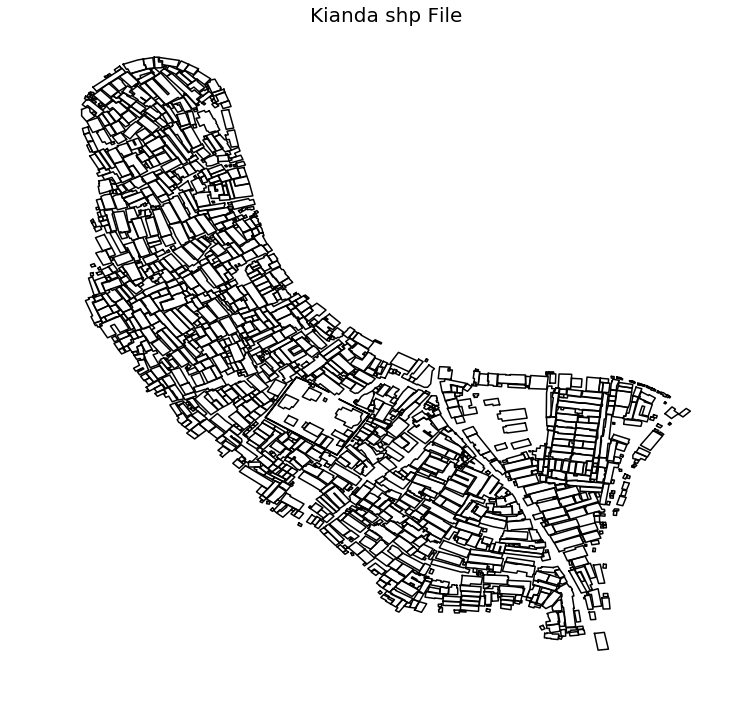

In [11]:
# import libraries
import shapefile as shp
import matplotlib.pyplot as plt

#load shapefile
#C:\Users\ymamo\Kibera\KIANDA_shapefile\KIANDA_STRUCTURES\KIANDA_population_A
sf = shp.Reader('.\\KIANDA_shapefile\\KIANDA_STRUCTURES\\KIANDA_population_A\\kianda_a.shp')

#plt.figure(figsize=(15,15))
fig2, ax2 = plt.subplots(1, figsize=(12,12))
_ = ax2.axis('off')
ax2.set_title("Kianda shp File", fontsize = 20)
for shape in sf.shapeRecords():
    
    # end index of each components of map
    l = shape.shape.parts
    
    len_l = len(l)  # how many parts of countries i.e. land and islands
    #print (len_l)
    x = [i[0] for i in shape.shape.points[:]] # list of latitude
    y = [i[1] for i in shape.shape.points[:]] # list of longitude
    l.append(len(x)) # ensure the closure of the last component
    for k in range(len_l):
        # draw each component of map.
        # l[k] to l[k + 1] is the range of points that make this component
        plt.plot(x[l[k]:l[k + 1]],y[l[k]:l[k + 1]], 'k-')

# display
plt.show()

# START MODULE TO CREATE DICTIONARY

In [1]:
import pandas as pd

from simpledbf import Dbf5

import numpy as np

dbf = Dbf5(".\\KIANDA_shapefile\\KIANDA_STRUCTURES\\Population_2\\kianda_structures_and_population_dataset.dbf")

df = dbf.to_dataframe()

df.head()



,MAT_WOO_D,FAM_S_D,RENT_STR,RENT_MEAN,BUSINESS,GEOMETRY,MAT_M_D,OWNER,RENT_MIN,WOMEN,...,RENT_MAX,MAT_IR,FAM_UP,POP_R,STRUCTURE,MAT_BR_D,STR_CODE,FAM_SP,FAM_S,SERV_O
0,0.0,0.0,1500,500,1.0,0.0,1.000,0.0,500.0,1.0,...,500.0,0.0,1.0,7.0,95.0,0.000,KIAS1S95S0,1.0,0.0,0.0
1,0.0,0.0,0,0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,KIAS0S0S0,0.0,0.0,0.0
2,0.0,0.0,0,0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,KIAS0S0S0,0.0,0.0,0.0
3,0.0,0.3,17000,1700,1.0,0.0,0.250,1.0,1000.0,7.0,...,2400.0,0.0,0.0,29.0,25.0,0.750,KIAS1S25S0,1.0,3.0,0.0
4,0.0,0.0,12000,4000,2.0,0.0,0.333,1.0,0.0,1.0,...,8000.0,0.0,0.0,3.0,24.0,0.667,KIAS1S24S0,1.0,0.0,0.0


In [4]:
rent = []

for num in df["RENT_MEAN"]:
    if num > 0: 
        rent.append(num)
print (sum(rent)/len(rent))

sum(df["RENT_MEAN"])/len(df["RENT_MEAN"])

1122.79441341


665.49735099337749

In [7]:
df[df["STR_CODE"] == '0S2S151S80']

,MAT_WOO_D,FAM_S_D,RENT_STR,RENT_MEAN,BUSINESS,GEOMETRY,MAT_M_D,OWNER,RENT_MIN,WOMEN,...,RENT_MAX,MAT_IR,FAM_UP,POP_R,STRUCTURE,MAT_BR_D,STR_CODE,FAM_SP,FAM_S,SERV_O
1359,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,151.0,0.0,0S2S151S80,0.0,0.0,0.0


In [151]:
len(df["FAMILIES"])

1510

In [152]:
families = 0
children = 0
for i in df.iterrows():
    families += i[1]["FAMILIES"]
    children += i[1]["CHILD"]
    
print (families, children)

6021.0 6918.0


In [153]:
#corrections

#Account for 2 women in one house (assume multi-generational or sisters--data counts as both parents,
#or prostitution ring with female pimps)
df.at[126,"FAM_S"] = 1
df.at[126,"FAM_C"] = 0
df.at[126,"FAM_SP"] = 1
df.at[126,"FAM_S"] = 1
df.at[126,"FAMILIES"] = 2

#Accoubt for polygamous family at 432 where numbers do not add up
df.at[432,"FAM_SP"] = 1
df.at[432,"FAM_C"] = 0
df.at[432,"FAM_P"] = 1


In [154]:

def get_breakdown(row):
    total = row["POP_R"]
    women = row["WOMEN"]
    children = row["CHILD"]
    men = total - (women + children)
    return men, women, children

def calc_rent(families, rent_mean, rent_str):
    rent_distro = []
    for fam in range(int(families)): 
        rent_distro.append(int(random.gauss(rent_mean, (rent_str*0.01))))
    #rent_distro.sort() 
    return rent_distro

def calc_children(num_child, num_families):
    
    if num_families == 0: 
        return int(num_child)
    else: 
        child_array = np.random.poisson(1.3, num_families)
        if sum(child_array) > num_child:
            while sum(child_array) > num_child:
                idx = random.randint(0, len(child_array))
                if child_array[idx-1] > 0:
                    child_array[idx-1] -= 1
        elif sum(child_array) < num_child:
            while sum(child_array) < num_child:
                idx = random.randint(0, len(child_array))
                child_array[idx-1] += 1
        else: 
            pass

        return child_array.tolist()



In [155]:
def divvy_men(num_men, array, level, single, deployed, s_par):
    #print ("SET_UP", num_men, array, single, deployed, s_par)
    while men > level: 
        if single > 0: 
            array[6] += 1
            num_men -= 1
            single -= 1
            if num_men == 0:
                break
        if deployed > 0: 
            array[8] += 1
            num_men -=1
            deployed -= 1
            if num_men == 0:
                break
        if random.randint(0,2) > 0 and s_par > 0: 
            array[4] += 1
            num_men -=1
            s_par -=1
            if num_men == 0:
                break
    return num_men, array, single, deployed, s_par

def divvy_women(num_w, array, level, single, deployed, s_par, poly):
    while women > level: 
        if s_par > 0: 
            array[5] += 1
            num_w -=1
            s_par -=1
            if num_w == 0:
                break
        if poly > 0: 
            array[3] += 1
            num_w -= 1
            poly -= 1
            if num_w == 0:
                break
        if deployed > 0: 
            array[9] += 1
            num_w -=1
            deployed -= 1
            if num_w == 0:
                break
        if single > 0: 
            array[7] += 1
            num_w -= 1
            single -= 1
            if num_w == 0:
                break
        
    return num_w, array, single, deployed, s_par, poly

def calc_parents(total, s_par, both_par, single, poly, deployed, men, women, house):
    #array breakdown 0 = both_par_m,1 =both_par_w, 2 = poly_m, 3 = poly_w, 4= s_par_m, 5 = s_par_w,
    #6= single_m, 7 = single_w, 8 = deployed_m, 9 = deployed_w
    #print ("INPUT", total, s_par, both_par, single, poly, deployed, men, women)
    fam_array = [0,0,0,0,0,0,0,0,0,0]
    fam_array[0] = both_par
    men -= both_par
    fam_array[1] = both_par
    women -=both_par
    fam_array[2] = poly
    men -= poly
    fam_array[3] = 2*poly
    women -= 2*poly
    #print (fam_array)
    #fix error in women count
    if women < 0: 
        while women < 0: 
            women += 1
            men -= 1
            print ("House " + str(house) + " data mismatch!")
            print ("INPUT", total, s_par, both_par, single, poly, deployed, men, women)
    if men < 0: 
        while men < 0: 
            women -= 1
            men += 1
            print ("House " + str(house) + " double female family!")
            print ("INPUT", total, s_par, both_par, single, poly, deployed, men, women)
    if women > 3: 
        women, fam_array, single, deployed, s_par, poly = divvy_women(women, fam_array,3, single, deployed, s_par, poly)
    #print ("test array", fam_array)
    if men > 2: 
        men, fam_array, single, deployed, s_par = divvy_men(men, fam_array,2, single, deployed, s_par)
    #print ("test array", fam_array)
    if women > 2: 
        women, fam_array, single, deployed, s_par, poly = divvy_women(women, fam_array,2, single, deployed, s_par, poly)
    if men > 1: 
        men, fam_array, single, deployed, s_par = divvy_men(men, fam_array,1, single, deployed, s_par)
    if women > 1: 
        women, fam_array, single, deployed, s_par, poly = divvy_women(women, fam_array,1, single, deployed, s_par, poly)
    if men > 0: 
        men, fam_array, single, deployed, s_par = divvy_men(men, fam_array,0, single, deployed, s_par)
    if women > 0: 
        women, fam_array, single, deployed, s_par, poly = divvy_women(women, fam_array,0, single, deployed, s_par, poly)
        
    return fam_array

In [158]:
def get_child(children):
    #print (children)
    if sum(children) > 0: 
        idx = random.randint(0,len(children))-1
        if children[idx] > 0:
            child = children[idx]
            children.pop(idx)
            #print ("ROW 1:", child, children)
            return child, children
        else: 
            for i in children: 
                if i >= 1: 
                    children.pop(children.index(i))
                    return i, children
    else: 
        children.pop(0)
        #print ("ROW 3", child, children)
        return 0, children
    
def remove_child(children):
    #print (children)
    if 0 not in children: 
        if len(children) > 1: 
            children[1] = children[0] + children[1]
            children.pop(0)
            return children
        else:  
            children.append(True)
            return children
    else: 
        for i in children: 
            if i == 0: 
                children.pop(children.index(i))
                return children
        
    
def row_to_dict(num_fams, rent, children, parent,agent_dict, fam_num, house):
    
    #print (num_fams, rent, children, parent,agent_dict, fam_num, house)
    #add single males to dictionary
    for single_m in range(parent[6]):
        fam_num += 1
        children = remove_child(children)
        agent_dict[fam_num] = {"Father": 1, "Mother": 0, "Children": 0,
                               "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        
        
    #add single females to dictionary
    for single_w in range(parent[7]):
        fam_num += 1
        children = remove_child(children)
        agent_dict[fam_num] = {"Father": 0, "Mother": 1, "Children": 0,
                               "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        
        
        
    #add deployed male to dictionary
    for single_m in range(parent[8]):
        fam_num += 1
        children = remove_child(children)
        agent_dict[fam_num] = {"Father": 1, "Mother": 0, "Children": 0,
                               "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        
        
    #add deployed female to dictionary
    for single_w in range(parent[9]):
        fam_num += 1
        children = remove_child(children)
        agent_dict[fam_num] = {"Father":0 , "Mother": 1, "Children": 0,
                               "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        
    #get single male parent families
    for single_par_m in range(parent[4]):
        fam_num += 1
        
        #print (type(children))
        child, children = get_child(children)
        agent_dict[fam_num] = {"Father": 1, "Mother": 0, "Children": child,
                               "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        
    #get single female parent families
    for single_par_w in range(parent[5]):
        fam_num += 1
        #print (type(children))
        child, children = get_child(children)
        agent_dict[fam_num] = {"Father": 0, "Mother": 1, "Children": child,
                              "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        
    #get married parents
    for married_coup in range(int(parent[0])):
        fam_num+= 1
        agent_dict[fam_num] = {"Father": 1, "Mother": 1, "Children": children[0],
                               "Structure" : house, "Rent" : rent[0]}
        rent.pop(0)
        children.pop(0)
     
    #get polygamous couples
    if parent[2] > 0: 
        num_wives = parent[3]/parent[2]
        remainder = parent[3] % parent[2]
    for poly in range(int(parent[2])):
            fam_num+=1
            if remainder > 0: 
                agent_dict[fam_num] = {"Father": 1, "Mother": (num_wives + 1) , "Children": children[0],
                                       "Structure" : house, "Rent" : rent[0]}
                remainder -=1
                rent.pop[0]
                children.pop(0)
            else: 
                agent_dict[fam_num] = {"Father": 1, "Mother": num_wives , "Children": children[0],
                                       "Structure" : house, "Rent" : rent[0]}
                rent.pop(0)
                children.pop(0)
        
    if len(children) > 1: 
        if children[-1] == True:
            #print (children)
            for new_fam in range(children[0]):
                agent_dict[fam_num] = {"Father": 0, "Mother": 0, "Children": 1,
                               "Structure" : house, "Rent" : 0}
                fam_num += 1
    #print (fam_num, num_fams)
    return agent_dict, fam_num

In [159]:
## 86 is row to fix

import random 

agent_dict = {}
fam_num = 0
for i in df.iterrows(): 
    print (i[0])
    num_fams = int(i[1]["FAMILIES"])
    #print (num_fams)
    #use helper function get_brekadown to calculate men
    men, women, children = get_breakdown(i[1])
    #print ("gender_break", men, women, children, "\n")
    #use helper function calc rent to calculate rent for family
    rent = calc_rent(i[1]['FAMILIES'], i[1]["RENT_MEAN"], i[1]["RENT_STR"])
    #print ("RENT", rent,i[1]["RENT_MIN"], i[1]["RENT_MAX"],"\n")
    child_array = calc_children(i[1]["CHILD"], int(i[1]["FAMILIES"]))
    #print ("CHILD ARRAY", sum(child_array), i[1]["CHILD"], child_array)
    fam_parent_array = calc_parents(i[1]["FAMILIES"], i[1]["FAM_SP"], i[1]["FAM_C"],i[1]["FAM_S"], i[1]["FAM_P"],
                                    i[1]["FAM_UP"], men, women, i[0])
    #array breakdown 0 = both_par_m,1 =both_par_w, 2 = poly_m, 3 = poly_w, 4= s_par_m, 5 = s_par_w,
    #6= single_m, 7 = single_w, 8 = deployed_m, 9 = deployed_w
    #print ("FAM PARENT ARRAY", fam_parent_array)
    #print ( i[1]["FAM_C"], i[1]["FAM_UP"], i[1]["FAM_SP"], i[1]["FAM_S"], i[1]["FAM_P"], "\n")
    #account for children living on their own
    if type(child_array) == int:
        for g in range(child_array):
            fam_num += 1
            agent_dict[fam_num] = {"Father": 0, "Mother": 0 , "Children": 1,
                                       "Structure" : i[1]["STR_CODE"], "Rent" : (i[1]["RENT_MEAN"]/child_array)}
    else: 
        agent_dict, fam_num = row_to_dict(num_fams, rent, child_array, fam_parent_array, agent_dict, fam_num, i[1]["STR_CODE"])
    
        
    
    
#print (agent_dict)
print (len(agent_dict.keys()))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
House 24 data mismatch!
INPUT 7.0 1.0 3.0 3.0 0.0 0.0 4.0 0.0
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
House 72 data mismatch!
INPUT 9.0 2.0 4.0 3.0 0.0 0.0 5.0 0.0
73
74
75
76
77
78
79
80
81
82
83
84
85
86
House 86 data mismatch!
INPUT 14.0 2.0 4.0 5.0 0.0 3.0 10.0 0.0
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
House 208 data mismatch!
INPUT 2.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0
209
210
211
212
213
214

In [162]:
children = 0
for fam in agent_dict.values():
    children += fam["Children"]
children

6911

In [303]:
for i in df[72:73].iterrows():
    print (i)

(72, MAT_WOO_D             0
FAM_S_D           0.333
RENT_STR          13200
RENT_MEAN          1650
BUSINESS              0
GEOMETRY              0
MAT_M_D               1
OWNER                 0
RENT_MIN           1500
WOMEN                 4
WATER                 0
VIL_CODE            KIA
ELECT_D            0.88
MAT_IR_D              0
FAM_UP_D              0
ROOMS                 8
SERV_H                0
BUSI_C                0
TOT_UNITS             8
EMPTY                 0
HOUSEHOLD             8
MAT_M                 8
SERVICE               0
DATE              80801
FAM_SP_D          0.222
POP_D             2.375
MAT_BR                0
FAM_C                 4
ELECT                 7
BUSI_P                0
FAM_C_D           0.444
CHILD_D           0.316
NO_INFO               0
MAT_WOO               0
CHILD                 6
FAMILIES              9
POP                  18
TOILET                3
SERV_EDU              0
WOMEN_D           0.158
FAM_P                 0
BUSI_S     

In [ ]:
males = []
females = []
children = []
population = []
for i in df.iterrows(): 
    not_males = 0
    if pd.notnull(i[1]["WOMEN"]):
        females.append(i[1]["WOMEN"])
        not_males += i[1]["WOMEN"]
    if pd.notnull(i[1]["CHILD"]):
        children.append(i[1]["CHILD"])
        not_males += i[1]["CHILD"]
    if pd.notnull(i[1]['POP_R']):
        population.append(i[1]['POP_R'])
    males_count = i[1]["POP_R"]-not_males
    if males_count < 0:
        print (i)
    males.append(males_count)

In [ ]:
males
#sum(population)

In [7]:
m = sum(males)
f = sum(females)
c = sum(children)
p = sum(population)


print ("total:", m+f+c)
print (p)

total: 15218.0
15218.0


In [8]:
df.keys()

Index(['MAT_WOO_D', 'FAM_S_D', 'RENT_STR', 'RENT_MEAN', 'BUSINESS', 'GEOMETRY',
       'MAT_M_D', 'OWNER', 'RENT_MIN', 'WOMEN', 'WATER', 'VIL_CODE', 'ELECT_D',
       'MAT_IR_D', 'FAM_UP_D', 'ROOMS', 'SERV_H', 'BUSI_C', 'TOT_UNITS',
       'EMPTY', 'HOUSEHOLD', 'MAT_M', 'SERVICE', 'DATE', 'FAM_SP_D', 'POP_D',
       'MAT_BR', 'FAM_C', 'ELECT', 'BUSI_P', 'FAM_C_D', 'CHILD_D', 'NO_INFO',
       'MAT_WOO', 'CHILD', 'FAMILIES', 'POP', 'TOILET', 'SERV_EDU', 'WOMEN_D',
       'FAM_P', 'BUSI_S', 'SHEET_N', 'FAM_P_D', 'RENT_MAX', 'MAT_IR', 'FAM_UP',
       'POP_R', 'STRUCTURE', 'MAT_BR_D', 'STR_CODE', 'FAM_SP', 'FAM_S',
       'SERV_O'],
      dtype='object')

In [118]:
dbf = Dbf5(".\\KIANDA_shapefile\\KIANDA_STRUCTURES\\KIANDA_uncertain\\uncertain0.dbf")

df_u = dbf.to_dataframe()

list(df_u)

['GEOMETRY',
 'VIL_CODE',
 'SHEET_N',
 'STRUCTURE',
 'DATE',
 'STR_CODE',
 'RESIDENT',
 'BUSINESS',
 'SERVICE',
 'EMPTY',
 'NO_INFO',
 'TOT_UNIT',
 'BUSI_C',
 'BUSI_P',
 'BUSI_S',
 'SERV_H',
 'SERV_EDU',
 'SERV_O',
 'ELECT',
 'WATER',
 'TOILET',
 'ROOMS',
 'POP',
 'FAMILIES',
 'FAM_S',
 'FAM_SP',
 'FAM_C',
 'FAM_P',
 'FAM_UP',
 'WOMEN',
 'CHILD',
 'MAT_IR',
 'MAT_WOO',
 'MAT_M',
 'MAT_BR',
 'MAT_TOT',
 'RENT_MIN',
 'RENT_MAX',
 'RENT_MIN_T',
 'RENT_MAX_T',
 'RENT_MEAN',
 'OWNER',
 'SUM_TRIBE',
 'LUO',
 'GIKUYU',
 'LUHYA',
 'KAMBA',
 'KISII',
 'TAITA',
 'TAVETA',
 'KALENJIN',
 'TURKANA',
 'MASAI',
 'TESO',
 'MERU',
 'OTHER_TR',
 'UGANDA',
 'TANZANI']

In [127]:
tribe = []
for i in df_u["LUO"]:
    if pd.notnull(i): 
        tribe.append(i)
sum(tribe)

0.0

In [130]:
dbf = Dbf5(".\\KIANDA_shapefile\\KIANDA_STRUCTURES\\KIANDA_population_A\\Owners\\owners.dbf")

df_o = dbf.to_dataframe()

list(df_o)

['GEOMETRY',
 'VIL_CODE',
 'SHEET_N',
 'STRUCTURE',
 'DATE',
 'STR_CODE',
 'RESIDENT',
 'BUSINESS',
 'SERVICE',
 'EMPTY',
 'NO_INFO',
 'BUSI_C',
 'BUSI_P',
 'BUSI_S',
 'SERV_H',
 'SERV_EDU',
 'SERV_O',
 'ELECT',
 'WATER',
 'TOILET',
 'ROOMS',
 'POP',
 'FAMILIES',
 'FAM_S',
 'FAM_SP',
 'FAM_C',
 'FAM_P',
 'FAM_UP',
 'WOMEN',
 'CHILD',
 'MAT_IR',
 'MAT_WOO',
 'MAT_M',
 'MAT_BR',
 'RENT_MIN',
 'RENT_MAX',
 'OWNER']

In [131]:
df_o

,GEOMETRY,VIL_CODE,SHEET_N,STRUCTURE,DATE,STR_CODE,RESIDENT,BUSINESS,SERVICE,EMPTY,...,FAM_UP,WOMEN,CHILD,MAT_IR,MAT_WOO,MAT_M,MAT_BR,RENT_MIN,RENT_MAX,OWNER
0,0.0,KIA,00,00,000000,KIA0000000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,KIA,01,07,000000,KIA0107000000,2.0,4.0,0.0,0.0,...,0.0,1.0,1.0,6.0,0.0,0.0,0.0,1000.0,1000.0,4.0
2,0.0,KIA,01,09,000000,KIA0109000000,3.0,2.0,0.0,0.0,...,0.0,2.0,11.0,3.0,0.0,2.0,0.0,1500.0,3000.0,1.0
3,0.0,KIA,01,14,000000,KIA0114000000,11.0,0.0,0.0,0.0,...,0.0,10.0,21.0,13.0,0.0,0.0,0.0,1200.0,2400.0,1.0
4,0.0,KIA,01,16,000000,KIA0116000000,2.0,0.0,0.0,0.0,...,0.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
5,0.0,KIA,01,24,000000,KIA0124000000,1.0,2.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,8000.0,1.0
6,0.0,KIA,01,25,000000,KIA0125000000,8.0,1.0,0.0,0.0,...,0.0,7.0,13.0,0.0,0.0,2.0,6.0,1000.0,2400.0,1.0
7,0.0,KIA,01,92,000000,KIA0192000000,6.0,0.0,0.0,0.0,...,0.0,4.0,18.0,0.0,0.0,7.0,0.0,1000.0,1700.0,1.0
8,0.0,KIA,02,04,080802,KIA0204080802,6.0,1.0,0.0,0.0,...,0.0,1.0,5.0,3.0,0.0,0.0,0.0,600.0,600.0,1.0
9,0.0,KIA,02,13,080802,KIA0213080802,6.0,1.0,0.0,0.0,...,0.0,6.0,17.0,0.0,0.0,6.0,0.0,1500.0,3000.0,1.0


# STUFF TO KEEP 


## cacultae possoin lambda

In [6]:
import numpy as np

lamb_array = []

x = 0

while x <= 5: 
    x += 1
    lamb = 0.1
    y = 0
    while y < children:
            y = sum(np.random.poisson(lamb,6021))
            #print (lamb)
            lamb += 0.1
    lamb_array.append(lamb)
lamb_array

[1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [7]:
lamb_array = []

x = 0

while x <= 5: 
    x += 1
    lamb = 5.0
    y = 8000
    while y > children:
            y = sum(np.random.poisson(lamb,6021))
            #print (y)
            lamb -= 0.1
    lamb_array.append(lamb)
lamb_array

[1.0000000000000009,
 1.0000000000000009,
 1.0000000000000009,
 1.0000000000000009,
 1.0000000000000009,
 1.0000000000000009]